In [20]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,  BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import tensorflow as tf

# Load the dataset
data = pd.read_csv('new_data.csv')

In [2]:
data.sample(10)

,Sentence,Sentiment
107,$NUAN held up well after the big gains! Maybe ...,1
2453,The costs of the new ropax vessels are 30 % lo...,1
390,"( ADPnews ) - Feb 3 , 2010 - Finland-based ste...",0
622,According to Nordic financial group Nordea 's ...,1
1982,The ` buy ' recommendation was reiterated .,1
706,New Credit Suisse boss faces stiff challenge i...,0
2532,$GOOGL Hit With Lawsuit from Russian Search En...,0
2298,Equity indexes working on a positive engulfing...,1
1855,$TNH Looks like an explosive setup if it can b...,1
961,The workforce will be reduced also in the Amst...,0


In [3]:
data.Sentiment.value_counts()

Sentiment
1    1852
0     860
Name: count, dtype: int64

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
stpwds_id = list(set(stopwords.words('english')))

In [5]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]


  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [6]:
data['text_processed'] = data['Sentence'].apply(lambda x: text_preprocessing(x))
data

,Sentence,Sentiment,text_processed
0,The GeoSolutions technology will leverage Bene...,1,geosolutions technology leverage benefon 's gp...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0,esi lows bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",1,last quarter componenta 's net sales doubled e...
3,$SPY wouldn't be surprised to see a green close,1,spy would n't surprised see green close
4,Shell's $70 Billion BG Deal Meets Shareholder ...,0,shell 's billion bg deal meets shareholder ske...
...,...,...,...
2707,Operating profit fell to EUR 38.1 mn from EUR ...,0,operating profit fell eur mn eur mn
2708,HSBC Says Unit to Book $585 Million Charge on ...,0,hsbc says unit book million charge settlement
2709,Daily Mail parent company in talks with potent...,1,daily mail parent company talks potential part...
2710,RISING costs have forced packaging producer Hu...,0,rising costs forced packaging producer huhtama...


In [7]:
data.Sentiment

0       1
1       0
2       1
3       1
4       0
       ..
2707    0
2708    0
2709    1
2710    0
2711    1
Name: Sentiment, Length: 2712, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.text_processed,  # Input features (preprocessed text)
    data.Sentiment,       # Target labels
    test_size=0.15,       # 15% of the data will be used for testing
    random_state=20,      # For reproducibility
    stratify=data.Sentiment  # Ensures that both training and test sets have similar label distribution
)



In [9]:
# Get Vocabularies
from sklearn.feature_extraction.text import CountVectorizer
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<2305x5630 sparse matrix of type '<class 'numpy.int64'>'
	with 23650 stored elements in Compressed Sparse Row format>

In [10]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  5630
Maximum Sentence Length :  33 tokens


In [11]:
# Text Vectorization

from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

2024-08-09 15:09:34.556714: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-09 15:09:34.556750: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-09 15:09:34.556756: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-09 15:09:34.557148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-09 15:09:34.557573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-09 15:09:34.772417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [12]:
# Embedding

from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [22]:
seed = 20
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

# Build the LSTM model
model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=64,
                     validation_split=0.1,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)])


Epoch 1/15
33/33 [==============================] - 5s 82ms/step - loss: 0.1907 - accuracy: 0.9253 - val_loss: 0.5227 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 2/15
33/33 [==============================] - 2s 48ms/step - loss: 0.0739 - accuracy: 0.9773 - val_loss: 0.5502 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 3/15
33/33 [==============================] - 1s 45ms/step - loss: 0.0417 - accuracy: 0.9860 - val_loss: 0.5020 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 4/15
33/33 [==============================] - 2s 47ms/step - loss: 0.0321 - accuracy: 0.9908 - val_loss: 0.4801 - val_accuracy: 0.7965 - lr: 0.0010
Epoch 5/15
33/33 [==============================] - 1s 44ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.4634 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 6/15
33/33 [==============================] - 1s 43ms/step - loss: 0.0272 - accuracy: 0.9908 - val_loss: 0.4651 - val_accuracy: 0.8009 - lr: 0.0010
Epoch 7/15
33/33 [==============================] - 1s 41ms/step - loss: 0.0

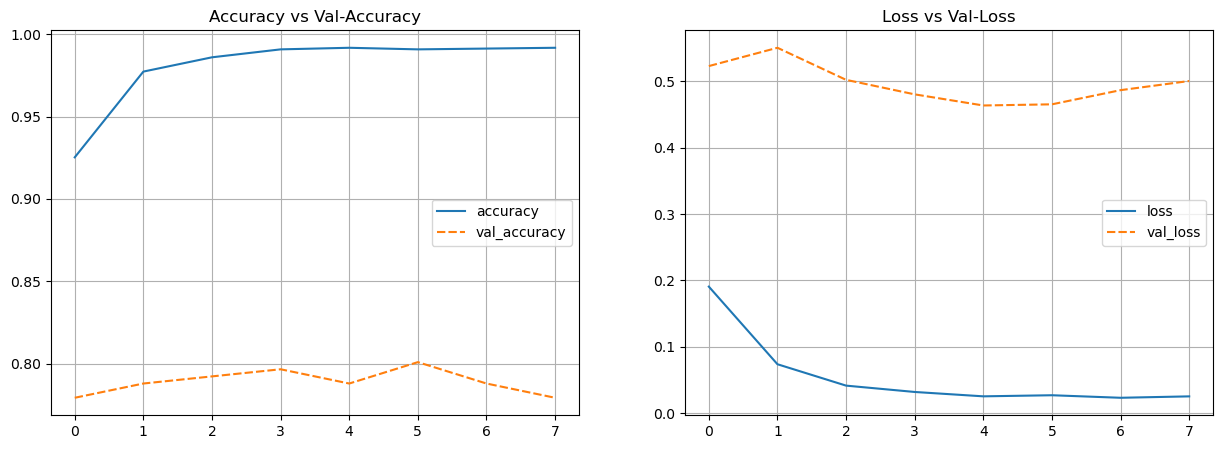

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

13/13 [==============================] - 0s 22ms/step - loss: 0.8384 - accuracy: 0.6437
Test Accuracy: 0.6437


In [25]:
from sklearn.metrics import classification_report

# Assuming you have trained your model and have X_test and y_test ready

# Step 1: Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary output

# Step 2: Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

# Step 3: Display the report
print(report)


13/13 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

    Negative       0.47      0.85      0.60       129
    Positive       0.89      0.55      0.68       278

    accuracy                           0.64       407
   macro avg       0.68      0.70      0.64       407
weighted avg       0.75      0.64      0.65       407



In [26]:
model.save('model.keras')